In [1]:
!mkdir ~/.kaggle
#!cp /content/.kaggle/kaggle.json ~/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
%cd '/content'

/content


In [2]:
!echo '{"username":"USER","key":"KEY"}' > /root/.kaggle/kaggle.json
!kaggle datasets download -d theblackmamba31/landscape-image-colorization

landscape-image-colorization.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
#unzipping the zip files and deleting the zip files
!unzip \*.zip  && rm *.zip

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
import numpy as np
import tensorflow as tf
import keras
import cv2
from keras.layers import MaxPool2D,Conv2D,UpSampling2D,Input,Dropout
from keras.models import Sequential
from keras.preprocessing.image import img_to_array
import os
from tqdm import tqdm
import re
import matplotlib.pyplot as plt

# to get the files in proper order
def sorted_alphanumeric(data):  
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [convert(c) for c in re.split('([0-9]+)',key)]
    return sorted(data,key = alphanum_key)
# defining the size of the image
SIZE = 160
color_img = []
path = '/content/landscape Images/color'
files = os.listdir(path)
files = sorted_alphanumeric(files)
for i in tqdm(files):
        
    img = cv2.imread(path + '/'+i,1)
    # open cv reads images in BGR format so we have to convert it to RGB
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    #resizing image
    img = cv2.resize(img, (SIZE, SIZE))
    img = img.astype('float32') / 255.0   
    color_img.append(img_to_array(img))


gray_img = []
path = '/content/landscape Images/gray'
files = os.listdir(path)
files = sorted_alphanumeric(files)
for i in tqdm(files):
    img = cv2.imread(path + '/'+i,1)

    #resizing image
    img = cv2.resize(img, (SIZE, SIZE))
    img = img.astype('float32') / 255.0
    gray_img.append(img_to_array(img))


100%|██████████| 7129/7129 [00:04<00:00, 1540.17it/s]


In [3]:
# defining function to plot images pair
def plot_images(color,grayscale):
    plt.figure(figsize=(15,15))
    plt.subplot(1,3,1)
    plt.title('Color Image', color = 'green', fontsize = 20)
    plt.imshow(color)
    plt.subplot(1,3,2)
    plt.title('Grayscale Image ', color = 'black', fontsize = 20)
    plt.imshow(grayscale)
   
    plt.show()

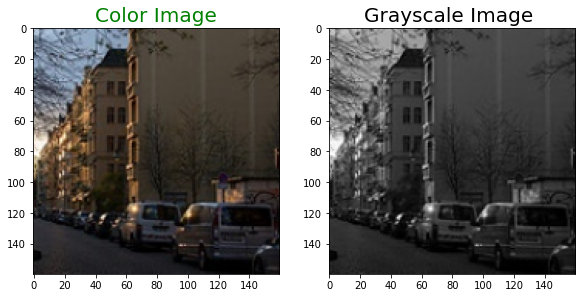

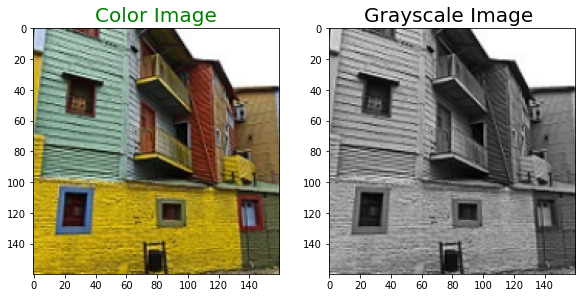

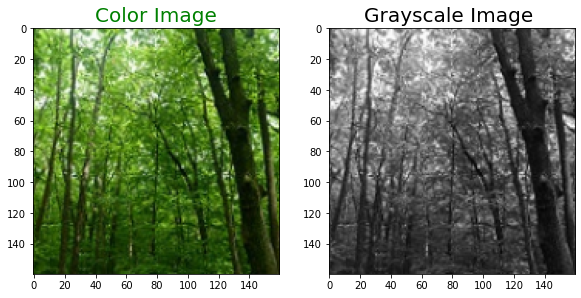

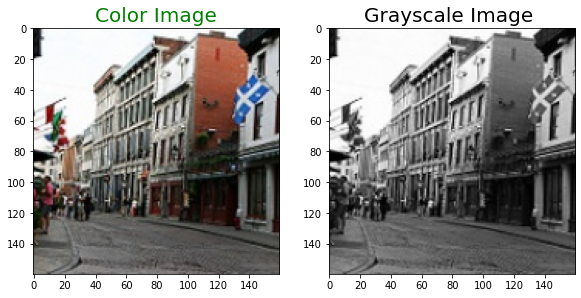

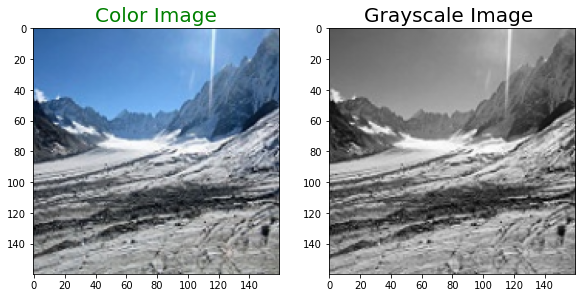

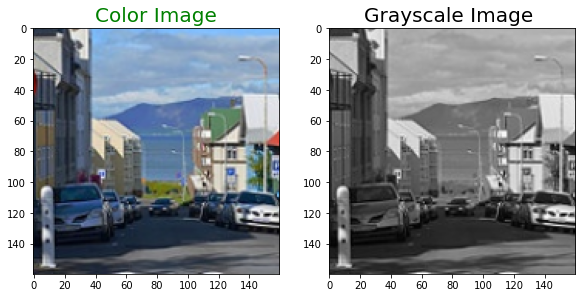

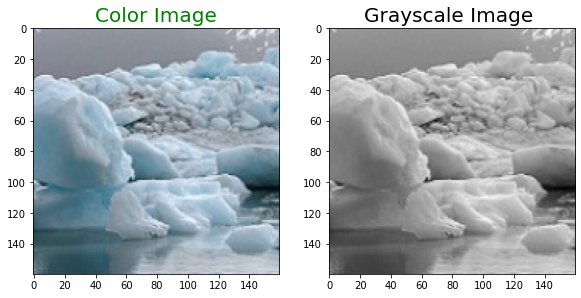

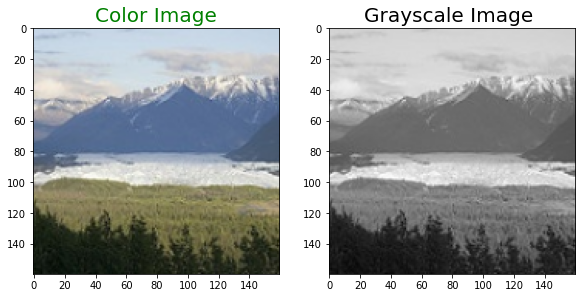

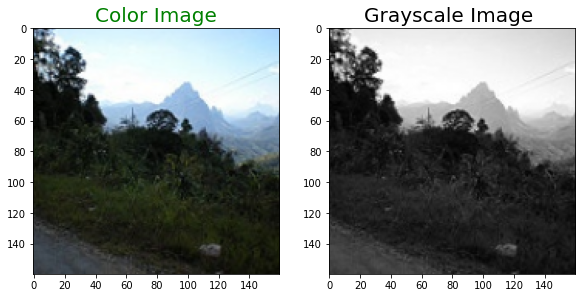

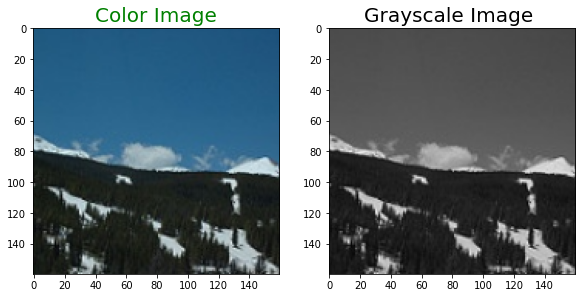

In [4]:
for i in range(10):
     plot_images(color_img[i],gray_img[i])

In [5]:
train_gray_image = gray_img[:6500]
train_color_image = color_img[:6500]

test_gray_image = gray_img[6500:]
test_color_image = color_img[6500:]
# reshaping
train_g = np.reshape(train_gray_image,(len(train_gray_image),SIZE,SIZE,3))
train_c = np.reshape(train_color_image, (len(train_color_image),SIZE,SIZE,3))
print('Train color image shape:',train_c.shape)


test_gray_image = np.reshape(test_gray_image,(len(test_gray_image),SIZE,SIZE,3))
test_color_image = np.reshape(test_color_image, (len(test_color_image),SIZE,SIZE,3))
print('Test color image shape',test_color_image.shape)

Train color image shape: (6500, 160, 160, 3)
Test color image shape (629, 160, 160, 3)


In [6]:
from keras import layers
def down(filters , kernel_size, apply_batch_normalization = True):
    downsample = tf.keras.models.Sequential()
    downsample.add(layers.Conv2D(filters,kernel_size,padding = 'same', strides = 2))
    if apply_batch_normalization:
        downsample.add(layers.BatchNormalization())
    downsample.add(keras.layers.LeakyReLU())
    return downsample


def up(filters, kernel_size, dropout = False):
    upsample = tf.keras.models.Sequential()
    upsample.add(layers.Conv2DTranspose(filters, kernel_size,padding = 'same', strides = 2))
    if dropout:
        upsample.dropout(0.2)
    upsample.add(keras.layers.LeakyReLU())
    return upsample

In [7]:
def model():
    inputs = layers.Input(shape= [160,160,3])
    d1 = down(128,(3,3),False)(inputs)
    d2 = down(128,(3,3),False)(d1)
    d3 = down(256,(3,3),True)(d2)
    d4 = down(512,(3,3),True)(d3)
    
    d5 = down(512,(3,3),True)(d4)
    #upsampling
    u1 = up(512,(3,3),False)(d5)
    u1 = layers.concatenate([u1,d4])
    u2 = up(256,(3,3),False)(u1)
    u2 = layers.concatenate([u2,d3])
    u3 = up(128,(3,3),False)(u2)
    u3 = layers.concatenate([u3,d2])
    u4 = up(128,(3,3),False)(u3)
    u4 = layers.concatenate([u4,d1])
    u5 = up(3,(3,3),False)(u4)
    u5 = layers.concatenate([u5,inputs])
    output = layers.Conv2D(3,(2,2),strides = 1, padding = 'same')(u5)
    return tf.keras.Model(inputs=inputs, outputs=output)

In [8]:
model = model()
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 80, 80, 128)  3584        input_1[0][0]                    
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 40, 40, 128)  147584      sequential[0][0]                 
__________________________________________________________________________________________________
sequential_2 (Sequential)       (None, 20, 20, 256)  296192      sequential_1[0][0]               
______________________________________________________________________________________________

In [9]:
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001), loss = 'mean_absolute_error',
              metrics = ['acc'])

model.fit(train_g, train_c, epochs = 100,batch_size = 50,verbose = 1)

Epoch 1/50
130/130 [==============================] - 65s 229ms/step - loss: 0.1808 - acc: 0.3762
Epoch 2/50
130/130 [==============================] - 31s 239ms/step - loss: 0.0624 - acc: 0.4605
Epoch 3/50
130/130 [==============================] - 33s 250ms/step - loss: 0.0571 - acc: 0.4757
Epoch 4/50
130/130 [==============================] - 34s 259ms/step - loss: 0.0534 - acc: 0.4913
Epoch 5/50
130/130 [==============================] - 33s 254ms/step - loss: 0.0513 - acc: 0.5014
Epoch 6/50
130/130 [==============================] - 33s 255ms/step - loss: 0.0500 - acc: 0.5126
Epoch 7/50
130/130 [==============================] - 33s 256ms/step - loss: 0.0493 - acc: 0.5173
Epoch 8/50
130/130 [==============================] - 33s 255ms/step - loss: 0.0475 - acc: 0.5308
Epoch 9/50
130/130 [==============================] - 33s 255ms/step - loss: 0.0465 - acc: 0.5325
Epoch 10/50
130/130 [==============================] - 33s 256ms/step - loss: 0.0460 - acc: 0.5406
Epoch 11/50
130/130

In [10]:
model.evaluate(test_gray_image,test_color_image)

20/20 [==============================] - 3s 96ms/step - loss: 0.0463 - acc: 0.5434


[0.04627413675189018, 0.5433999300003052]

In [11]:
model.save('colourizationModel.h5')

In [ ]:
# defining function to plot images pair
def plot_images(color,grayscale,predicted):
    plt.figure(figsize=(15,15))
    plt.subplot(1,3,1)
    plt.title('Color Image', color = 'green', fontsize = 20)
    plt.imshow(color)
    plt.subplot(1,3,2)
    plt.title('Grayscale Image ', color = 'black', fontsize = 20)
    plt.imshow(grayscale)
    plt.subplot(1,3,3)
    plt.title('Predicted Image ', color = 'Red', fontsize = 20)
    plt.imshow(predicted)
   
    plt.show()

    #checking results
for i in range(30,315):
    predicted = np.clip(model.predict(test_gray_image[i].reshape(1,SIZE, SIZE,3)),0.0,1.0).reshape(SIZE, SIZE,3)
    plot_images(test_color_image[i],test_gray_image[i],predicted)